In [1]:
pwd

'/home/samuel'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max.columns",None)
import gc

In [3]:
import mxnet as mx
from mxnet import gluon, np

In [4]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_train = pd.read_csv('~/Documents/Books/DataScience/Datasets/Recommender system dataset/ml-100k/ua.base',sep='\t',names=r_cols,encoding='latin-1')
ratings_test = pd.read_csv('~/Documents/Books/DataScience/Datasets/Recommender system dataset/ml-100k/ua.test',sep='\t',names=r_cols,encoding='latin-1')
ratings_train.shape, ratings_test.shape

((90570, 4), (9430, 4))

In [5]:
# pass in column names for each CSV as the column name is not given in the file and read them using pandas.
# You can check the column names from the readme file

# reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('~/Documents/Books/DataScience/Datasets/Recommender system dataset/ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('~/Documents/Books/DataScience/Datasets/Recommender system dataset/ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

# reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('~/Documents/Books/DataScience/Datasets/Recommender system dataset/ml-100k/u.item', sep='|', names=i_cols,
encoding='latin-1')

# After loading the dataset, we should look at the content of each file (users, ratings, items).

# Looking at the user file
print("\nUser Data :")
print("shape : ", users.shape)
print(users.head())

# We have 943 users in the dataset and each user has 5 features, i.e. user_ID, age, sex, occupation and zip_code. Now let’s look at the ratings file.

# Ratings Data
print("\nRatings Data :")
print("shape : ", ratings.shape)
print(ratings.head())

# We have 100k ratings for different user and movie combinations. Now finally examine the items file.

# Item Data
print("\nItem Data :")
print("shape : ", items.shape)
print(items.head())


User Data :
shape :  (943, 5)
   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213

Ratings Data :
shape :  (100000, 4)
   user_id  movie_id  rating  unix_timestamp
0      196       242       3       881250949
1      186       302       3       891717742
2       22       377       1       878887116
3      244        51       2       880606923
4      166       346       1       886397596

Item Data :
shape :  (1682, 24)
   movie id        movie title release date  video release date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995     

In [6]:
ratings.shape, ratings_train.shape, ratings_test.shape

((100000, 4), (90570, 4), (9430, 4))

In [7]:
ratings.nunique()

user_id             943
movie_id           1682
rating                5
unix_timestamp    49282
dtype: int64

## Building collaborative filtering model from scratch

In [8]:
#calculating number of unique users snd movies
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

In [9]:
# creating a user-item matrix that will be used to calculate the similarity between users and items
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [10]:
data_matrix.shape

(943, 1682)

In [ ]:
# calsulating the similarity between users and item using pairwise_distance
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix, metric='cosine')

In [ ]:
# now that we have the item-item and user-user similarity, now we make predictions based on similarities

def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user-rating[:, np.newaxis])
        #using np.newaxis so that mean_user_rating has same format as ratings
        pred = mean_user_rating[;, np.newaxis] + similarity.dot(ratings_diff) / np.arry([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [ ]:
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')

In [9]:
class MF():
    """
        Initializing the user-movie rating matrix, no. of latent features,
        alpha and beta
        R – The user-movie rating matrix
        K – Number of latent features
        alpha – Learning rate for stochastic gradient descent
        beta – Regularization parameter for bias
        iterations – Number of iterations to perform stochastic gradient descent
    """
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
    # Intializing user - feature and movie movie-feature matrix
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Intializing the bais terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
    
        #List of training smaples
        self.samples = [
            (i,j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
    
        #Stochastic gradiet secent for give number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sdg()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
        return training_process
    
    # computing total MSE
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)
    
    #stocatic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            predicton = self.get_rating(i, j)
            e = (r - prediction)
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            self.P[i, :] += self.alpha * (e*self.Q[j, :] - self.beta * self.P[i,:])
    
    #Ratings for user i and moovie j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    #full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:, np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)



In [10]:
R = np.array(ratings.pivot(index = 'user_id', columns ='movie_id', values ='rating').fillna(0))

In [ ]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q")
print(f.full_matrix())
print()

In [9]:
ratings_train.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [38]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


100000

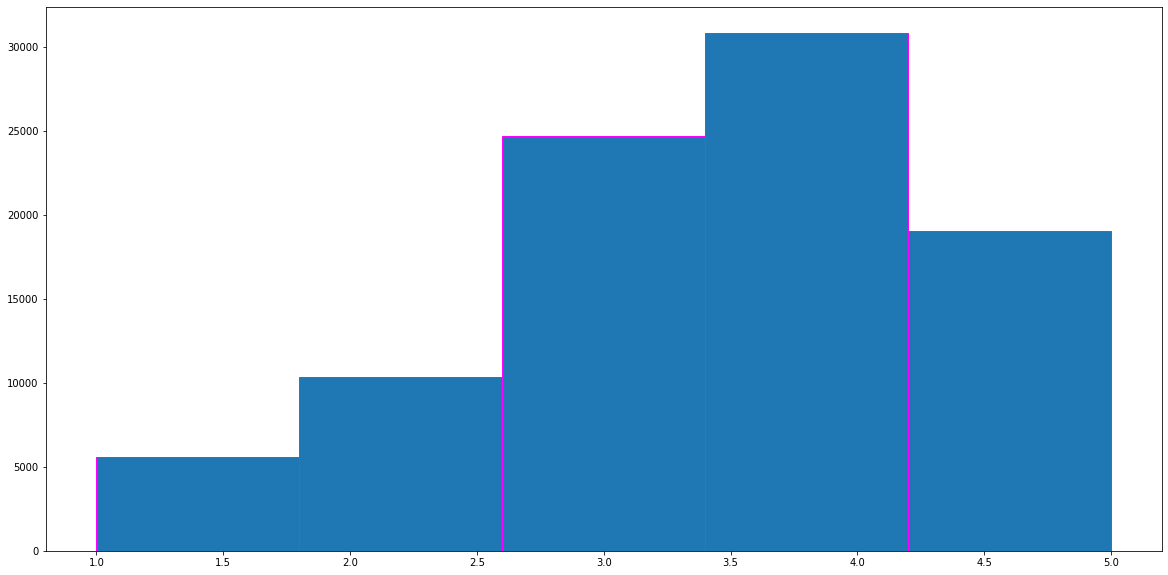

In [23]:
plt.figure(figsize=(20,10))
plt.hist(ratings_train['rating'], bins=5, ec='magenta')
plt.show()

In [28]:
ratings_train.isnull().any()

user_id           False
movie_id          False
rating            False
unix_timestamp    False
dtype: bool

In [29]:
ratings_test.isnull().any()

user_id           False
movie_id          False
rating            False
unix_timestamp    False
dtype: bool

In [30]:
ratings_train.dtypes

user_id           int64
movie_id          int64
rating            int64
unix_timestamp    int64
dtype: object

In [32]:
train = ratings_train.copy()
test = ratings_test.copy()

[here](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/)